# Benchmark Model Predicted Results vs Experiments

04/30/2023

Andrew Weng

In [1]:
import os, sys

# Move the path up a level to be able to index into source files
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    sys.path.insert(0, 'src/')

from src import cellsim as cellsim 

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.signal import savgol_filter
from src import plotter as plotter

%matplotlib widget
%load_ext autoreload

# Load the Experimental Data

In [2]:
plotter.initialize(plt)
target_dir = os.getcwd()
target_dir_arbin = f'{target_dir}/data/raw/from-voltaiq'
file_indices_to_include = np.array([1])

cellid = 152064

if cellid == 152098: # FAST FORMATION 2

    file_arbin_list = [
        f'{target_dir_arbin}/UMBL2022FEB_CELL152098_FORMTAP_2_P45C_5P0PSI_20220901_R1.csv',
        f'{target_dir_arbin}/UMBL2022FEB_CELL152098_FORMFAST_2_P45C_5P0PSI_20220902_R1.csv',
        f'{target_dir_arbin}/UMBL2022FEB_CELL152098_FORMAGING_1_P45C_5P0PSI_20220909_R1.csv',
        f'{target_dir_arbin}/UMBL2022FEB_CELL152098_CYC_1C1CR1_P45C_5P0PSI_20220923_R1.csv'
                    ]

    daq_channel = 'Key_CH2'

    hr_max = 6

elif cellid == 152064: # BASELINE FORMATION (repeat 1)
    
    file_arbin_list = [
    f'{target_dir_arbin}/UMBL2022FEB_CELL152064_FORMTAP_2_P45C_5P0PSI_20220901_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152064_FORMBASE_1_P45C_5P0PSI_20220902_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152064_FORMAGING_1_P45C_5P0PSI_20220909_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152064_CYC_1C1CR1_P45C_5P0PSI_20220923_R1.csv'
                    ]

    daq_channel = 'Key_CH1'

    hr_max = 65


elif cellid == 152071: # FAST FORMATION 1
    
    file_arbin_list = [
    f'{target_dir_arbin}/UMBL2022FEB_CELL152071_FORMTAP_2_P45C_5P0PSI_20220901_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152071_FORMFAST_1_P45C_5P0PSI_20220902_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152071_FORMAGING_1_P45C_5P0PSI_20220909_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152071_CYC_1C1CR1_P45C_5P0PSI_20220923_R1.csv'
                    ]

    daq_channel = 'Key_CH3'

    hr_max = 16


elif cellid == 152074: # BASELINE FORMATION (repeat 2)
    
    file_arbin_list = [
    f'{target_dir_arbin}/UMBL2022FEB_CELL152074_FORMTAP_2_P45C_5P0PSI_20220901_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152074_FORMBASE_1_P45C_5P0PSI_20220902_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152074_FORMAGING_1_P45C_5P0PSI_20220909_R1.csv',
                    ]

    daq_channel = 'Key_CH0'

    hr_max = 65

# Load the Arbin Data
df_arbin_list = []

for file in np.array(file_arbin_list)[file_indices_to_include]:

    df = pd.read_csv(file)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['Timestamp']= df['Timestamp'].apply(lambda x : x.tz_localize(None))
    df_arbin_list.append(df)

df_arbin = pd.concat(df_arbin_list, axis=0)

# Load the Keyence data
file_keyence = f'{target_dir}/data/raw/from-keyence/keyence_20220901_213928.csv'
df_keyence = pd.read_csv(file_keyence)
df_keyence['computer time'] = pd.to_datetime(df_keyence['computer time'], unit='s')
df_keyence['computer time'] = df_keyence['computer time'].apply(lambda x : x.tz_localize(None))

# Filter the Keyence data
df_keyence = df_keyence.loc[(df_keyence['computer time'] > df_arbin['Timestamp'].iloc[0]) & \
                            (df_keyence['computer time'] < df_arbin['Timestamp'].iloc[-1])]
y_strain = df_keyence[daq_channel] - df_keyence[daq_channel].iloc[0]
y_strain[y_strain > 500] = np.NaN

/var/folders/qr/bx1pzh1x6nnbdrjvw2qhqkf40000gn/T/ipykernel_83518/1096240128.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_voltage.iloc[np.where(tv/3600 > hr_max)] = np.NaN


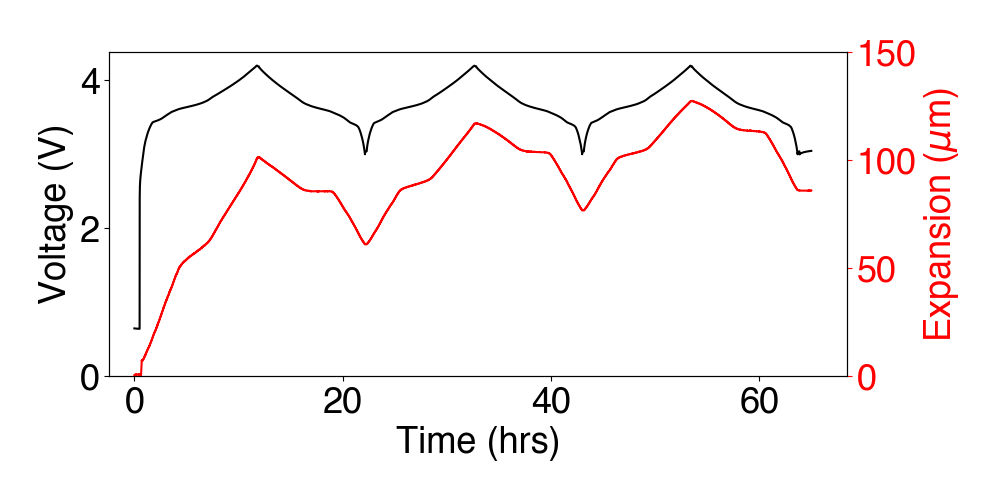

In [3]:
plt.figure(figsize=(10,5))

# The voltage plot
ax1 = plt.subplot()

ii = df_arbin['Current (A)']
qq = df_arbin['Charge Capacity (Ah)']
tv = df_arbin['Timestamp'].astype(int)
tv = (tv - np.min(tv)) / 1e9
y_voltage = df_arbin['Potential (V)']

y_voltage.iloc[np.where(tv/3600 > hr_max)] = np.NaN

ax1.plot(tv/3600, y_voltage, color='k')
ax1.set_xlabel('Time (hrs)')
ax1.set_ylabel('Voltage (V)')
ax1.set_ylim(bottom=0)
ax1.grid(False)
ax1.set_xlim((-0.1 * 24, 2.85 * 24))

# The expansion plot
ax2 = ax1.twinx()

tt = df_keyence['computer time'].astype(int)
tt = (tt - np.min(tt)) / 1e9

y_strain.iloc[np.where(tt/3600 > hr_max)] = np.NaN

ax2.plot(tt/3600, y_strain, color='r')
ax2.set_ylabel(r'Expansion ($\mu$m)')
ax2.tick_params(axis='y', colors='r')
ax2.yaxis.label.set_color('red')
ax2.set_ylim(bottom=0, top=150)
ax2.grid(False)

plt.savefig(f'outputs/figures/fig_strain_vs_voltage_cell{cellid}.png', dpi=300)

# Run the simulation

In [4]:
%autoreload

Q0 = 2.35      # Ah
Ichg = 2.5/10  # A
Idch = -2.5/10 # A
Icv = 2.5/20   # A

vmax = 4.2
vmin = 3.0

cell = cellsim.Cell()
cell.load_config('params/single.yaml')
sim = cellsim.Simulation(cell, 73*3600)

sim.run_rest(1, rest_time_hrs=0.5)
sim.run_chg_cccv(2, Ichg, Icv, vmax)
sim.run_dch_cccv(2, Idch, Idch, vmin)
sim.run_chg_cccv(3, Ichg, Icv, vmax)
sim.run_dch_cccv(3, Idch, Idch, vmin)
sim.run_chg_cccv(4, Ichg, Icv, vmax)
sim.run_dch_cccv(4, Idch, Idch, vmin)
sim.run_rest(5, rest_time_hrs=1)

df_sim = sim.get_results()
df_sim['dq'] = np.abs(df_sim['dt'] * df_sim['i_app'] / 3600)

Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...
Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc5: Rest for 1 hours...


/Users/aweng/code/formation-modeling/src/cellsim.py:520: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'outputs/figures/{self.name}_output.png',
/Users/aweng/code/formation-modeling/venv/lib/python3.8/site-packages/ipympl/backend_nbagg.py:336: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.figure.savefig(buf, format='png', dpi='figure')


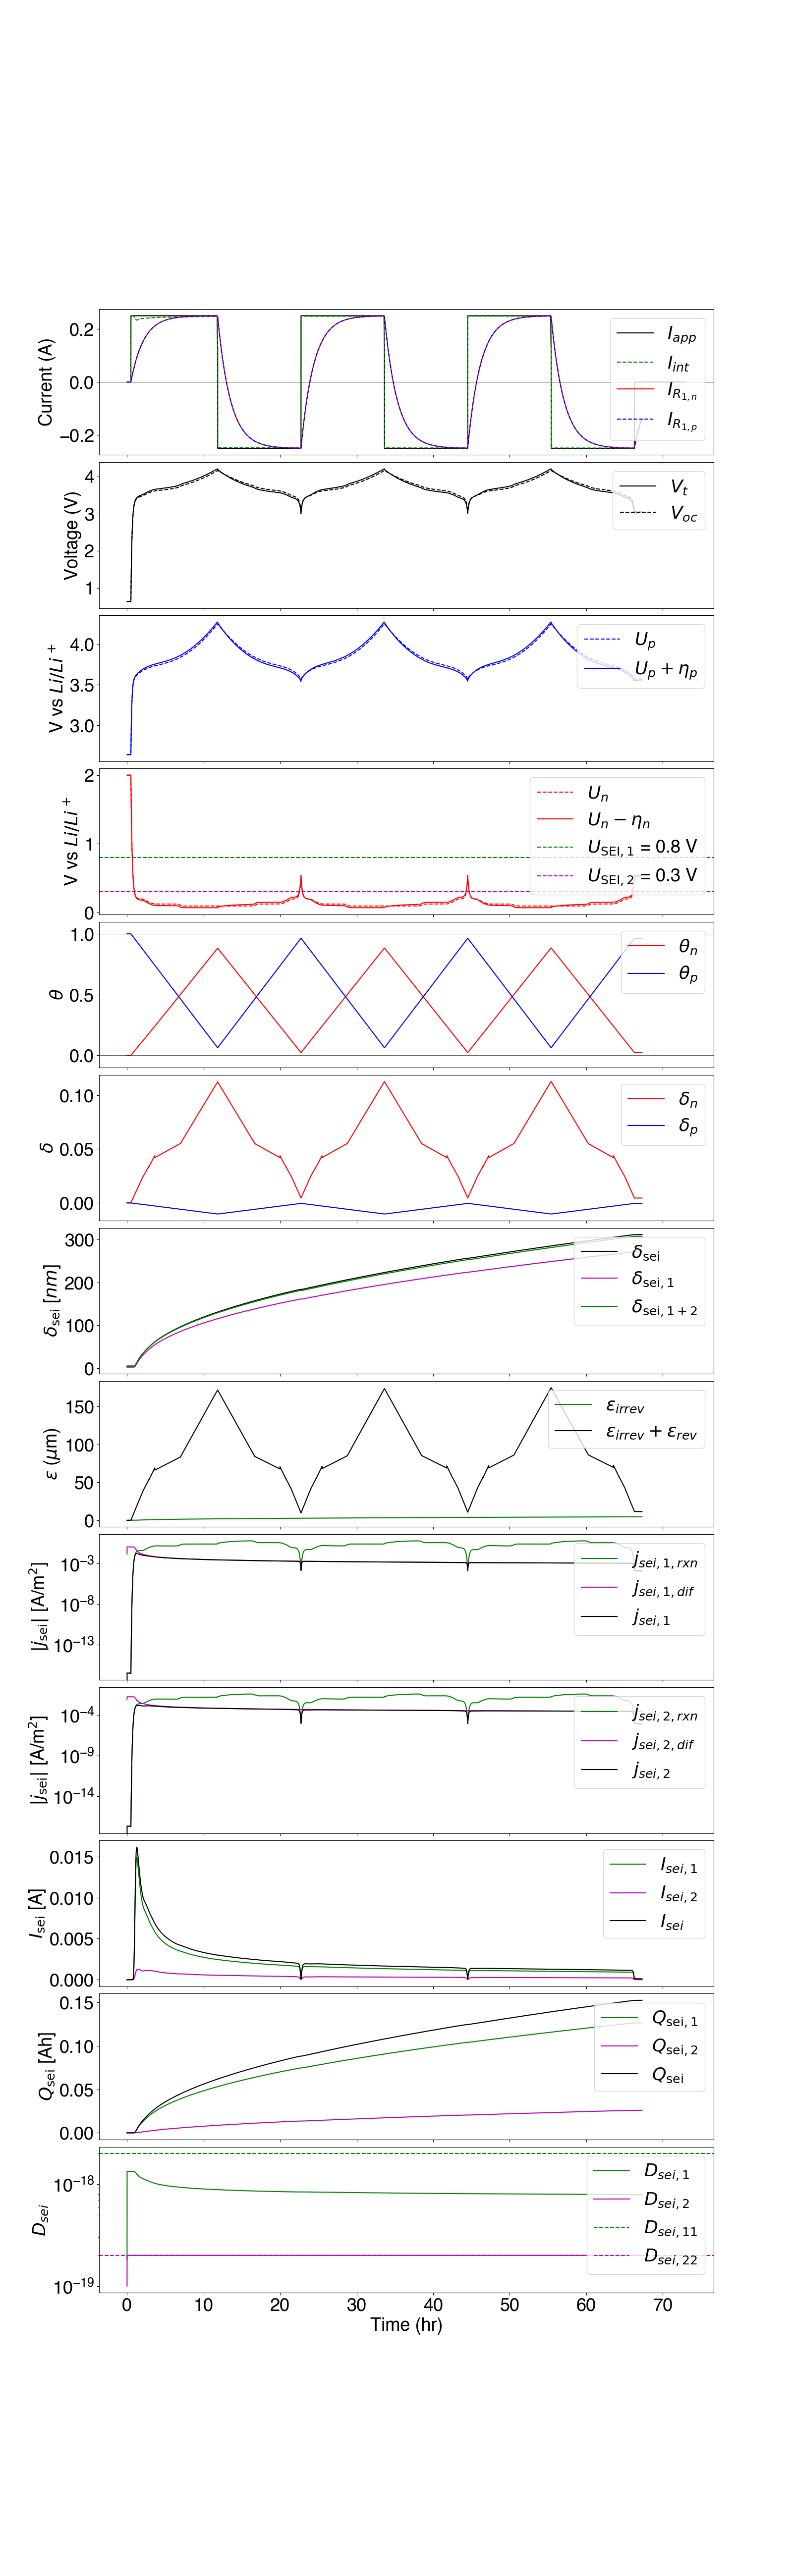

In [5]:
sim.plot()

# Compare Voltages

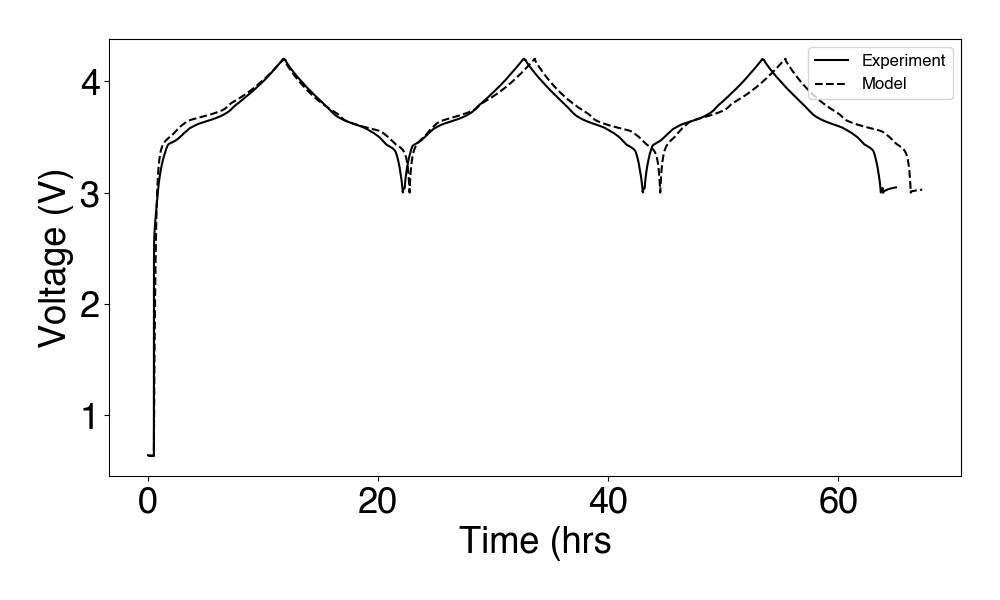

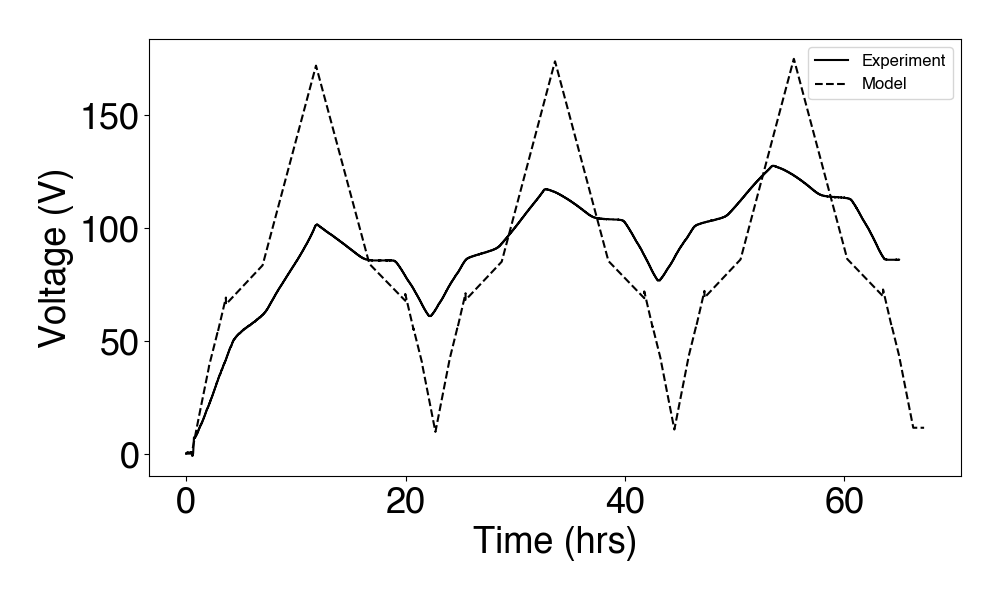

In [6]:
exp_sim = df_sim['expansion_rev'] + df_sim['expansion_irrev']
v_sim = df_sim['vt']
t_sim = df_sim['t']

plt.figure(figsize=(10,6))
plt.grid(False)
plt.plot(tv/3600, y_voltage, c='k', label='Experiment')
plt.plot(t_sim/3600, v_sim, c='k', ls='--', label='Model')
plt.legend(loc='upper right', fontsize=12)
plt.xlabel('Time (hrs')
plt.ylabel('Voltage (V)')

plt.figure(figsize=(10,6))
plt.grid(False)
plt.plot(tt/3600, y_strain, c='k', label='Experiment')
plt.plot(t_sim/3600, exp_sim*1e6, c='k', ls='--', label='Model')
plt.xlabel('Time (hrs)')
plt.ylabel('Voltage (V)')
plt.legend(loc='upper right', fontsize=12)

# Compare the dQ/dV during the first and second cycles

/var/folders/qr/bx1pzh1x6nnbdrjvw2qhqkf40000gn/T/ipykernel_83518/2747109645.py:51: RuntimeWarning: divide by zero encountered in divide
  plt.plot(qq1, dv1/dt1, c='r', label='Experiment, Cyc 1')


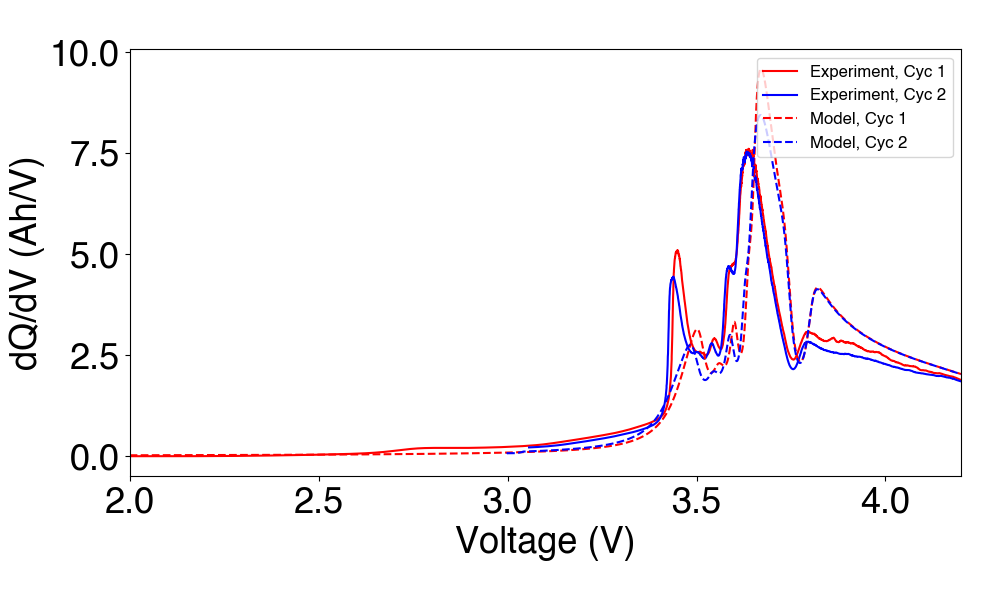

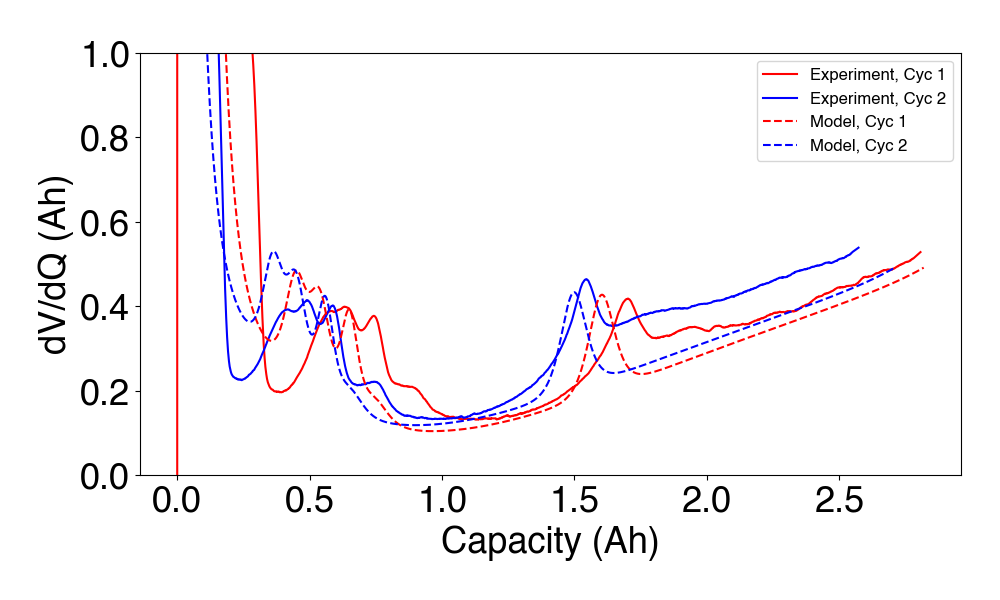

In [7]:

idx = np.where(tv/3600 < 11.74)[0]
qq1 = qq[idx]
vv1 = y_voltage[idx]

idx = np.where((tv/3600 > 22.31) & (tv/3600 < 32.61))[0]
qq2 = qq[idx]
vv2 = y_voltage[idx]

size_factor = 65
window_length = int(len(qq1) / size_factor)
window_length = window_length + 1 if window_length % 2 == 0 else window_length
polyorder = 2

# SG filter on the data to make it smooth
dt1 = savgol_filter(qq1, window_length, polyorder, 1)
dt2 = savgol_filter(qq2, window_length, polyorder, 1)
dv1 = savgol_filter(vv1, window_length, polyorder, 1)
dv2 = savgol_filter(vv2, window_length, polyorder, 1)

# Simulated data

df_sim1 = df_sim[df_sim['cycle_number'] == 2]
df_sim1 = df_sim1[df_sim1['step_number'] == 0]

df_sim2 = df_sim[df_sim['cycle_number'] == 3]
df_sim2 = df_sim2[df_sim2['step_number'] == 0]

qqsim1 = np.cumsum(df_sim1['dq'])
qqsim2 = np.cumsum(df_sim2['dq'])
vvsim1 = df_sim1['vt']
vvsim2 = df_sim2['vt']

dts1 = savgol_filter(qqsim1, window_length, polyorder, 1)
dts2 = savgol_filter(qqsim2, window_length, polyorder, 1)
dvs1 = savgol_filter(vvsim1, window_length, polyorder, 1)
dvs2 = savgol_filter(vvsim2, window_length, polyorder, 1)

# Make the plot
plt.figure(figsize=(10,6))
plt.plot(vv1, dt1/dv1, c='r', label='Experiment, Cyc 1')
plt.plot(vv2, dt2/dv2, c='b', label='Experiment, Cyc 2')
plt.plot(vvsim1, dts1/dvs1, c='r', ls='--', label='Model, Cyc 1')
plt.plot(vvsim2, dts2/dvs2, c='b', ls='--', label='Model, Cyc 2')
plt.xlabel('Voltage (V)')
plt.ylabel('dQ/dV (Ah/V)')
plt.grid(False)
plt.xlim((2, 4.2))
plt.legend(loc='upper right', fontsize=12)

plt.figure(figsize=(10,6))
plt.plot(qq1, dv1/dt1, c='r', label='Experiment, Cyc 1')
plt.plot(qq2, dv2/dt2, c='b', label='Experiment, Cyc 2')
plt.plot(qqsim1, dvs1/dts1, c='r', ls='--', label='Model, Cyc 1')
plt.plot(qqsim2, dvs2/dts2, c='b', ls='--', label='Model, Cyc 2')
plt.ylim((0, 1))
plt.xlabel('Capacity (Ah)')
plt.ylabel('dV/dQ (Ah)')
plt.grid(False)
plt.legend(loc='upper right', fontsize=12)

# Compare coulombic efficiency at each cycle

In [11]:
df_arbin.describe()

,[Arbin] AC Impedance (Ω),[Arbin] AC Impedance Phase Angle (°),[Arbin] Charge Capacity (Ah),[Arbin] Charge Energy (Wh),[Arbin] Current (A),[Arbin] Cycle Number,[Arbin] Datapoint Number,[Arbin] Date Time (excel format),[Arbin] Discharge Capacity (Ah),[Arbin] Discharge Energy (Wh),...,Charge Energy (Wh),Current (A),Cycle Number,Datapoint Number,Discharge Capacity (Ah),Discharge Energy (Wh),Potential (V),Step Index,Step Time (s),Test Time (s)
count,64158.0,64158.0,64158.000000,64158.000000,64158.000000,64158.000000,64158.000000,64158.000000,64158.000000,64158.000000,...,64158.000000,64158.000000,64158.000000,64158.000000,64158.000000,64158.000000,23616.000000,64158.000000,64158.000000,64158.000000
mean,0.0,0.0,1.031110,3.778577,0.003939,19.978771,32079.500000,44809.807259,0.927373,3.472493,...,3.778577,0.003939,19.978771,32079.500000,0.927373,3.472493,3.650098,13.237227,17097.891971,291073.539700
std,0.0,0.0,1.132858,4.195514,0.783786,16.671674,18520.963622,1.859247,1.076162,3.986854,...,4.195514,0.783786,16.671674,18520.963622,1.076162,3.986854,0.415414,8.706134,18110.630926,160622.656876
min,0.0,0.0,0.000000,0.000000,-2.499914,1.000000,1.000000,44806.438125,0.000000,0.000000,...,0.000000,-2.499914,1.000000,1.000000,0.000000,0.000000,0.635164,1.000000,0.000002,0.059668
25%,0.0,0.0,0.000000,0.000000,-0.124924,3.000000,16040.250000,44808.278166,0.006943,0.022302,...,0.000000,-0.124924,3.000000,16040.250000,0.006943,0.022302,3.522452,5.000000,951.355493,158978.106880
50%,0.0,0.0,0.327298,1.085101,0.000000,18.000000,32079.500000,44809.848819,0.125932,0.522422,...,1.085101,0.000000,18.000000,32079.500000,0.125932,0.522422,3.657958,13.000000,12017.771825,294666.650915
75%,0.0,0.0,2.545492,9.472247,0.124767,39.000000,48118.750000,44811.308652,2.269242,8.478807,...,9.472247,0.124767,39.000000,48118.750000,2.269242,8.478807,3.884558,21.000000,28132.072363,420773.587447
max,0.0,0.0,2.814124,10.393870,2.499757,40.000000,64158.000000,44813.165382,2.546351,9.393824,...,10.393870,2.499757,40.000000,64158.000000,2.546351,9.393824,4.200145,28.000000,73471.303075,581194.344157


In [12]:
df_arbin.columns

Index(['[Arbin] AC Impedance (Ω)', '[Arbin] AC Impedance Phase Angle (°)',
       '[Arbin] Charge Capacity (Ah)', '[Arbin] Charge Energy (Wh)',
       '[Arbin] Current (A)', '[Arbin] Cycle Number',
       '[Arbin] Datapoint Number', '[Arbin] Date Time (excel format)',
       '[Arbin] Discharge Capacity (Ah)', '[Arbin] Discharge Energy (Wh)',
       '[Arbin] dV/dT (V/s)', '[Arbin] Internal Resistance (Ω)',
       '[Arbin] Is Fast Capture', '[Arbin] Potential (V)',
       '[Arbin] Step Index', '[Arbin] Step Time (s)', '[Arbin] Test Time (s)',
       'Test Cumulative Capacity (Ah)', 'Test Cumulative Energy (Wh)',
       'Test Net Capacity (Ah)', 'Test Net Energy (Wh)', 'dQ/dV (Ah/V)',
       'dV/dt (V/s)', 'Power (W)', 'Current Cycle Net Capacity (Ah)',
       'Current Cycle Net Energy (Wh)', 'Charge Capacity (Ah)',
       'Charge Energy (Wh)', 'Current (A)', 'Cycle Number', 'Datapoint Number',
       'Timestamp', 'Discharge Capacity (Ah)', 'Discharge Energy (Wh)',
       'Potential (V)',

In [19]:
# Measured coulombic efficiency
df_meas_agg = df_arbin.groupby(['Cycle Number'])['Charge Capacity (Ah)', 'Discharge Capacity (Ah)'].agg('max')
df_meas_agg = df_meas_agg.iloc[0:3]
df_meas_agg['ce'] = df_meas_agg['Discharge Capacity (Ah)'] / df_meas_agg['Charge Capacity (Ah)']


/var/folders/qr/bx1pzh1x6nnbdrjvw2qhqkf40000gn/T/ipykernel_83518/3932421923.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_meas_agg = df_arbin.groupby(['Cycle Number'])['Charge Capacity (Ah)', 'Discharge Capacity (Ah)'].agg('max')


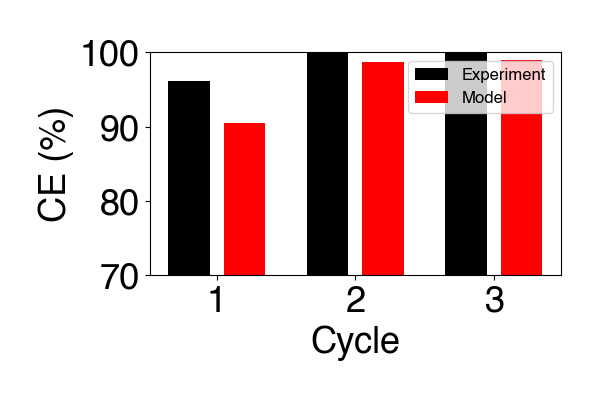

In [23]:

# Simulated coulombic efficiency
df_agg = df_sim.groupby(['cycle_number', 'step_number'])['dq'].agg('sum')
ce = []
cycle_index = np.array([2, 3, 4])
for i in cycle_index:
    ce.append(df_agg[i][2] / (df_agg[i][0] + df_agg[i][1]))
ce = np.array(ce)

# Make the plot
plt.figure(figsize=(6, 4))
xx = np.array([1, 2, 3])
plt.bar(xx-0.2, ce*100, color='k', width=0.3, label='Experiment')
plt.bar(xx+0.2, df_meas_agg['ce']*100, color='r', width=0.3, label='Model')

plt.ylabel('CE (%)')
plt.grid(False)
plt.xlabel('Cycle')
plt.legend(loc='upper right', fontsize=12)
plt.ylim([70, 100])
plt.show()


Text(0, 0.5, '$U_n$')

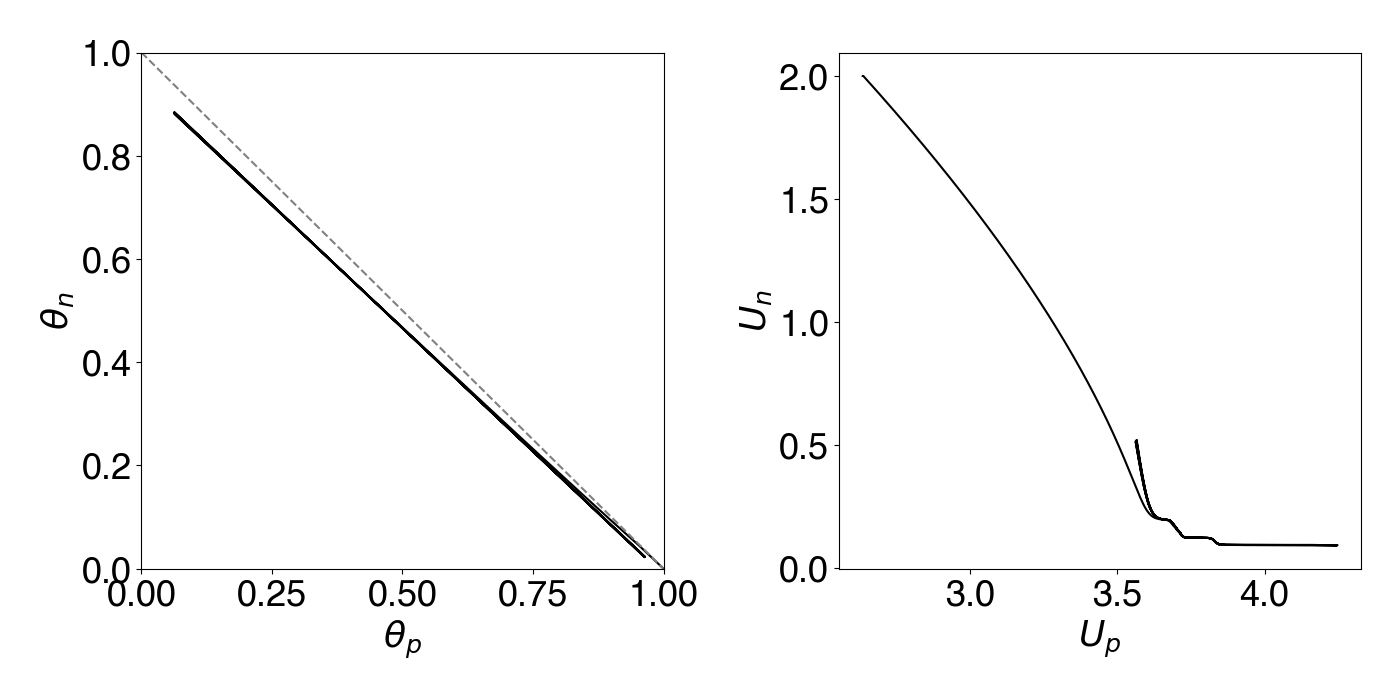

In [10]:
fh, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

xx = np.linspace(0, 1, 100)
ax0.plot(sim.theta_p, sim.theta_n, c='k')
ax0.plot(xx, 1-xx, c=(0.5,0.5,0.5), ls='--')
ax0.set_xlabel(r'$\theta_p$')
ax0.set_ylabel(r'$\theta_n$')
ax0.grid(False)
ax0.set_xlim((0,1))
ax0.set_ylim((0,1))

ax1.plot(sim.ocv_p, sim.ocv_n, c='k')
ax1.grid(False)
ax1.set_xlabel(r'$U_p$')
ax1.set_ylabel(r'$U_n$')